In [729]:
from __future__ import annotations
import typing
from dataclasses import dataclass, field
import warnings
from contextlib import contextmanager
import itertools
import functools

In [730]:
import numpy as np
import matplotlib.pyplot as plt

In [731]:
@contextmanager
def localize_globals(*exceptions: str, restore_values: bool = True):
    exceptions: typing.Set[str] = set(exceptions)

    old_globals: typing.Dict[str, typing.Any] = dict(globals())
    allowed: typing.Set[str] = set(old_globals.keys())
    allowed.update(exceptions)

    yield None

    new_globals: typing.Dict[str, typing.Any] = globals()

    for name in tuple(new_globals.keys()):
        if name not in allowed:
            del new_globals[name]
    
    if not restore_values:
        return
    
    new_globals.update(
        {k: v for k, v in old_globals.items() if k not in exceptions}
    )

In [732]:
# Not actual typevars, but just exist to satisfy the typechecker
N = typing.TypeVar('N')
M = typing.TypeVar('M')

In [733]:
def solve_newton(
    f: typing.Callable[[np.ndarray['N']], np.ndarray['M']],
    jacobian_f: typing.Callable[[np.ndarray['N']], np.ndarray['M,N']],
    x0: np.ndarray['N'],
    *,
    eps: float = 1e-8,
    max_iter: int = 1000,
) -> np.ndarray['N']:
    x: np.ndarray['N'] = x0.copy()
    
    try:
        for _ in range(max_iter):
            delta_x = np.linalg.solve(jacobian_f(x), -f(x))
            
            x += delta_x
            if np.linalg.norm(f(x)) < eps:
                break
    except np.linalg.LinAlgError:
        print(">", x, f(x), jacobian_f(x), flush=True)
        warnings.warn("Singular matrix encountered, falling back to scipy")
        raise
        # Screw it :(
        from scipy.optimize import root
        return root(f, x0, jac=jacobian_f).x
    
    return x

In [734]:
# TODO: Implicit method, actually!

@dataclass(frozen=True)
class ButcherTable:
    c: np.ndarray['N']
    a: np.ndarray['N,N']
    b: np.ndarray['N']
    
    def __post_init__(self):
        assert self.c.shape == (self.rank,), "Bad shape of c"
        assert self.a.shape == (self.rank, self.rank), "Bad shape of a"
        assert self.b.shape == (self.rank,), "Bad shape of b"
        
        assert np.isclose(self.c.sum(), 1), "Sum of c is not equal to 1"
        assert np.allclose(self.a.sum(axis=1), self.c), "Sum of a rows is not equal to c"
        assert np.allclose(self.b.sum(), 1), "Sum of b is not equal to 1"
    
    @property
    def rank(self) -> int:
        return len(self.c)
    
    def compute_ks(
        self,
        f: typing.Callable[[float, np.ndarray['N']], np.ndarray['N']],
        jac_f: typing.Callable[[float, np.ndarray['N']], np.ndarray['N,N']],
        t: float,
        u: np.ndarray['N'],
        step: float,
    ) -> np.ndarray['N,N']:
        # Wanted: ks[i, j] = f(t + c[i] * step, u + step * sum(a[i, k] * ks[k, :] for k in range(rank)))
        
        # rhs(ks) := {f(t + c * step, u + step * sum(a * ks))} - ks
        
        def rhs(ks: np.ndarray['N*N']) -> np.ndarray['N*N']:
            ks = ks.reshape((self.rank, self.rank))
            ts: np.ndarray['N'] = t + self.c * step
            # Wanted: us[i, j] = u[j] + step * sum(a[i, k] * ks[k, j] for k in range(rank))
            us: np.ndarray['N,N'] = u + step * (self.a @ ks)
            result = np.array([f(t, u) for t, u in zip(ts, us)]) - ks
            assert result.shape == (self.rank, self.rank), "Bad rhs shape"
            return result.flatten()
        
        def jac_rhs(ks: np.ndarray['N*N']) -> np.ndarray['N*N,N*N']:
            ks = ks.reshape((self.rank, self.rank))
            ts: np.ndarray['N'] = t + self.c * step
            us: np.ndarray['N,N'] = u + step * (self.a @ ks)
            result = np.zeros((self.rank, self.rank, self.rank, self.rank))
            
            # Screw matrix operations, I'm tired of that bullshit
            for i, j in itertools.product(range(self.rank), range(self.rank)):
                for k, l in itertools.product(range(self.rank), range(self.rank)):
                    result[i, j, k, l] = jac_f(ts[i], us[i])[j, k] * step * self.a[i, l]
                result[i, j, i, j] -= 1

            assert result.shape == (self.rank, self.rank, self.rank, self.rank), "Bad jac_rhs shape"
            return result.reshape((self.rank ** 2, self.rank ** 2))
        
        result = solve_newton(
            rhs,
            jac_rhs,
            np.random.rand(self.rank ** 2)
        )
        # assert np.allclose(rhs(result), 0), "Bad result"
        return result.reshape((self.rank, self.rank))
    
    def compute_next(
        self,
        f: typing.Callable[[float, np.ndarray['N']], np.ndarray['M']],
        jac_f: typing.Callable[[float, np.ndarray['N']], np.ndarray['M,N']],
        t: float,
        u: np.ndarray['N'],
        step: float,
    ) -> np.ndarray['M']:
        ks: np.ndarray['N,N'] = self.compute_ks(f, jac_f, t, u, step)
        return u + step * (self.b @ ks)


In [735]:
BUTCHER_TABLE: typing.Final[ButcherTable] = ButcherTable(
    c=np.array([0., 1.]),
    a=np.array([
        [0., 0.],
        [1./2, 1./2]
    ]),
    b=np.array([1./2, 1./2])
)


In [736]:
def solve_cauchy(
    f: typing.Callable[[float, np.ndarray['N']], np.ndarray['M']],
    jac_f: typing.Callable[[float, np.ndarray['N']], np.ndarray['M,N']],
    u0: np.ndarray['N'],
    *,
    t_end: float,
    steps: int = 100,
    butcher_table: ButcherTable = BUTCHER_TABLE,
) -> np.ndarray['steps+1,N']:
    t: float = 0.
    step: float = t_end / steps
    us: np.ndarray['steps+1,N'] = np.zeros((steps + 1, len(u0)))
    us[0, :] = u0
    
    for i in range(steps):
        us[i + 1] = butcher_table.compute_next(f, jac_f, t, us[i], step)
        t += step
    
    return us


In [737]:
def process_sample(steps: int = 100, plot_values: bool = False) -> np.ndarray['steps+1,2']:
    """
    Returns the absolute delta between the exact solution and the numerical one
    """
    
    # The equation is y'' = -y, y(0) = 0, y'(0) = 1
    # The equivalent system is u = (y, y'),
    #     u'(t) = f(t, u) = (u[1], -u[0])
    #     u(0) = (0, 1)
    # The exact solution is y(t) = sin(t), so u(t) = (sin(t), cos(t))
    
    # f = lambda t, u: np.array([np.cos(t), -np.sin(t)])
    # jac_f = lambda t, u: np.array([[np.cos(t), -np.sin(t)], [np.cos(t), -np.sin(t)]])
    f = lambda t, u: np.array([u[1], -u[0]])
    jac_f = lambda t, u: np.array([[0., -1.], [1., 0.]])
    u0: np.ndarray['2'] = np.array([0., 1.])
    t_end: float = 10.
    grid = np.linspace(0, t_end, steps + 1)
    
    us = solve_cauchy(f, jac_f, u0, t_end=t_end, steps=steps)
    
    true_us = np.array([[
        np.sin(t),
        np.cos(t),
    ] for t in grid])
    
    if plot_values:
        fig, ax = plt.subplots()
        
        ax.plot(grid, us[:, 0], label="u_0")
        ax.plot(grid, us[:, 1], label="u_1")
        ax.plot(grid, true_us[:, 0], label="true u_0", linestyle="--")
        ax.plot(grid, true_us[:, 1], label="true u_1", linestyle="--")
        
        ax.set_ylim(-3, 3)
        
        ax.legend()
    
    return np.abs(us - true_us)

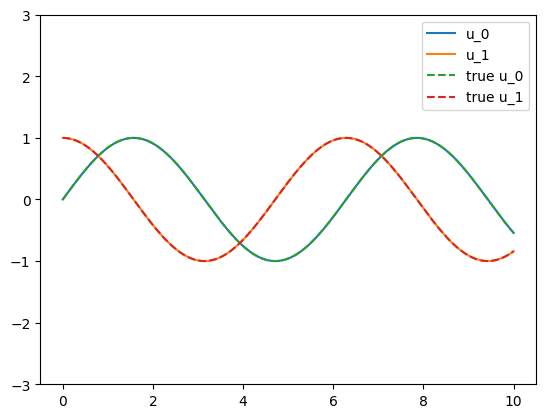

In [738]:
with localize_globals():
    np.random.seed(42)
    
    process_sample(steps=250, plot_values=True)


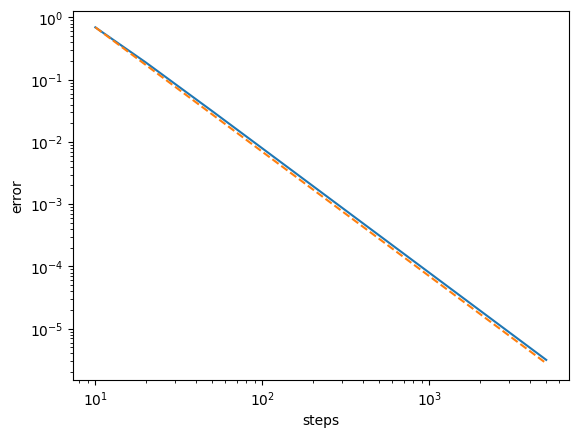

In [745]:
with localize_globals():
    np.random.seed(42)
    
    steps_values = np.array([10, 20, 50, 100, 200, 500, 1000, 2000, 5000])
    
    errors = np.array([np.max(process_sample(steps=steps)) for steps in steps_values])
    
    baseline = 1. / steps_values ** 2
    baseline *= errors[0] / baseline[0]
    
    fig, ax = plt.subplots()
    
    ax.plot(steps_values, errors)
    ax.plot(steps_values, baseline, linestyle="--")
    
    ax.set_xlabel("steps")
    ax.set_ylabel("error")
    
    ax.set_xscale("log")
    ax.set_yscale("log")
